# Time series forecasting in TensorFlow (BitPredict 💰📈)

## Introduction

Bitcoin is the most widely known and traded cryptocurrency, characterized by high volatility and unpredictable price movements.  
Accurately forecasting Bitcoin prices is a challenging task due to its complex patterns, high noise, and sensitivity to global events. However, with advances in machine learning and time series analysis, we can develop models that attempt to capture trends and make meaningful predictions.

In this project, we explore multiple modeling techniques to predict Bitcoin prices based on historical data.  
We compare deep learning models (like LSTM and Bi-LSTM) with traditional statistical methods (like ARIMA) and hybrid approaches (like Prophet) to understand their strengths and limitations.

---

## Objectives

- To preprocess and visualize historical Bitcoin price data.
- To apply different modeling techniques for forecasting:
  - Dense Neural Networks
  - LSTM Networks
  - Bidirectional LSTM Networks
  - ARIMA Time Series Models
  - Facebook Prophet Model
- To evaluate and compare model performances.
- To visualize predicted vs actual Bitcoin prices.

---

## Models Used

### 1. Naive Forecast Model (Naive Bias)
used as our baseline model to compare it to all models we build


### 2. Dense (Fully Connected) Neural Network
A simple feedforward neural network where all neurons are connected across layers.  
Serves as a baseline model for comparison.

### 3. LSTM (Long Short-Term Memory) Network
A type of RNN that can capture long-term dependencies in sequential data.  
Ideal for financial time series forecasting where previous patterns influence future outcomes.

### 4. Bi-LSTM (Bidirectional LSTM) Network
An advanced LSTM variant that reads sequences in both forward and backward directions.  
Captures complex temporal relationships in Bitcoin price movements.

### 5. ARIMA (AutoRegressive Integrated Moving Average) Model
A classical time series forecasting model that combines autoregression, differencing, and moving average components.  
We experiment with two ARIMA configurations: (29,1,30) and (15,1,15).

### 6. Prophet Model
A time series forecasting tool developed by Facebook.  
Captures seasonality, trends, and holiday effects easily with minimal tuning.

---

## Approach

The workflow in this project includes:
- Loading and preprocessing the Bitcoin dataset.
- Visualizing trends and patterns.
- Preparing data for deep learning and time series models.
- Training and validating each model separately.
- Comparing model performances based on prediction accuracy and visualization.

---

## Conclusion

By experimenting with various models, we aim to understand:
- Which models perform best on volatile financial time series.
- How deep learning models compare to traditional statistical methods.
- How different hyperparameters affect model performance.

This project not only focuses on achieving good forecasting results but also on learning how different modeling strategies can be applied to real-world financial data.

---


## Importing Required Libraries

In this section, we import all the necessary libraries and tools required for data loading, preprocessing, modeling, and visualization.

- **Pandas** and **NumPy**: For data manipulation and numerical operations.
- **Seaborn** and **Matplotlib**: For data visualization.
- **Plotly**: For creating interactive plots.
- **TensorFlow/Keras**: For building deep learning models like LSTM and Bi-LSTM.
- **Statsmodels**: For statistical modeling and time series analysis (ADF test, ARIMA modeling, etc.).
- **Prophet**: A forecasting tool developed by Facebook for time series predictions.
- **Warnings**: To suppress future warnings for cleaner output.

We also set a consistent visual style using Seaborn's theme settings.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import os
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Set seaborn theme
sns.set_theme()


c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

![example time series problems](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)

| Problem Type | Examples | Output |
| ----- | ----- | ----- |
| **Classification** | Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number) |

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

Can you guess what kind of problem BitPredict 💰📈 is?

---
---

## Evaluation Metrics Function

To assess the performance of our forecasting models, we define a utility function `evaluate_preds()` that calculates key regression evaluation metrics:

- **MAE (Mean Absolute Error)**: Measures the average magnitude of errors without considering their direction.
- **MSE (Mean Squared Error)**: Measures the average squared difference between predicted and actual values, penalizing larger errors more heavily.
- **RMSE (Root Mean Squared Error)**: Square root of MSE; interpretable in the same units as the original data.
- **MAPE (Mean Absolute Percentage Error)**: Measures prediction accuracy as a percentage; useful for understanding relative errors.

This function takes the true and predicted values, computes the metrics using TensorFlow's built-in functions, and returns them as a dictionary.  
It also handles cases where the MAPE value could become `NaN` or `Inf` by resetting it to `0.0` to ensure robust evaluation.


In [ ]:
def evaluate_preds(y_true, y_pred):

    """
    Evaluates the predictions of a model using common regression metrics:
    MAE, MSE, RMSE, and MAPE.

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Estimated target values.

    Returns:
        dict: A dictionary containing MAE, MSE, RMSE, and MAPE scores.
    """
        
    # Ensure inputs are tensors
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)

    # MAE
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mae_metric.update_state(y_true, y_pred)
    mae = mae_metric.result().numpy()

    # MSE
    mse_metric = tf.keras.metrics.MeanSquaredError()
    mse_metric.update_state(y_true, y_pred)
    mse = mse_metric.result().numpy()

    # RMSE
    rmse = tf.sqrt(mse).numpy()

    # MAPE
    mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
    mape_metric.update_state(y_true, y_pred)
    mape = mape_metric.result().numpy()

    # Handle inf/nan in MAPE
    if tf.math.is_nan(mape) or tf.math.is_inf(mape):
        mape = 0.0

    return {
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "mape": mape
    }


## Format Data Part 2: Windowing dataset

Surely we'd be ready to start building models by now?

We're so close! Only one more step (really two) to go.

We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![windows and horizons for turning time series data into a supervised learning problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)

*Example of windows and horizons for Bitcoin data. Windowing can be used to turn time series data into a supervised learning problem.*

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [4]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=5)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3] -> Label: [4 5 6 7 8]


In [5]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

## Purpose
The `make_train_test_splits` function splits the input windows and their corresponding labels into training and testing datasets. It allows for an easy way to partition data for model training, typically using 80% of the data for training and 20% for testing, with the option to adjust the test split ratio.


In [6]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels



## Purpose
The `create_model_checkpoint` function creates a TensorFlow Keras `ModelCheckpoint` callback, which saves the model during training. It saves the best version of the model (based on validation performance) to a specified directory, allowing you to resume training or use the best model for evaluation or inference.


In [ ]:
def create_model_checkpoint(model_name, save_path='D:\\data science projects\\project 2 unfinished'):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name + ".keras"),
        verbose=1,
        save_best_only=True
    )

## Purpose
The `adf_test` function performs the Augmented Dickey-Fuller (ADF) test on a time series to check for stationarity. It evaluates whether the time series has a unit root and prints the ADF statistic, p-value, and the result of the test, indicating whether the series is stationary or not.


In [8]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")


## Purpose
The `actual_30_days` function loads Bitcoin price data from a CSV file, processes the data by converting the 'Date' column to a datetime format, and resamples the data to daily frequency, keeping the last price for each day. It then returns the price data for the last 30 days, excluding any missing values.


In [9]:
def actual_30_days():
    actualData=pd.read_csv(r"D:\data science projects\project 2 unfinished\bitcoin_ohlc.csv")
    actualData['Date']=pd.to_datetime(actualData['Date'])
    actualData.set_index('Date', inplace=True)
    actualData = actualData.resample('D').last().dropna()
    actualData=actualData[2:]['Price']
    return actualData

## Purpose
The `plot_actual_forecast` function plots the forecasted Bitcoin prices alongside the actual prices over time. It visualizes the predicted prices for the next 30 days and compares them with the actual data to assess the model's performance and accuracy.


In [10]:
def plot_actual_forecast(forecast,actualData):
    plt.figure(figsize=(20, 5))
    plt.plot(forecast.index, forecast.values, label='Day Forecast')
    plt.plot(actualData.index,actualData.values,label='Actual data')
    plt.xlabel('Days Ahead')
    plt.ylabel('Predicted Price')
    plt.title('Bitcoin Price Forecast for Next 30 Days')
    plt.legend()
    plt.grid(True)
    plt.show()

## Purpose
The `wrangle` function processes and cleans Bitcoin price data from a CSV file. It parses the datetime column, handles missing values, resamples the data to daily frequency, and formats the datetime column. The function also removes duplicates, drops the 'Timestamp' column, and sets the 'datetime' column as the index before returning the cleaned dataset.


In [12]:
def wrangle(path):
    data=pd.read_csv(path,parse_dates=['datetime'])
    data.dropna(inplace=True)
    data['datetime']=pd.to_datetime(data['datetime'])
    data.set_index('datetime',inplace=True)
    data=data.resample('D').last()
    data = data.reset_index()
    data['datetime'] = data['datetime'].dt.strftime('%Y-%#m-%#d')
    data.set_index('datetime',inplace=True)
    data.drop_duplicates(inplace=True)
    data.drop(columns='Timestamp',inplace=True)
    return data

In [13]:
data=wrangle("D:\\data science projects\\project 2 unfinished\\btcusd_1-min_data.csv")

In [14]:
data

,Open,High,Low,Close,Volume
datetime,,,,,
2012-1-1,4.84,4.84,4.84,4.84,0.000000
2012-1-2,5.00,5.00,5.00,5.00,0.000000
2012-1-3,5.29,5.29,5.29,5.29,0.000000
2012-1-4,5.57,5.57,5.57,5.57,0.000000
2012-1-5,6.42,6.42,6.42,6.42,0.000000
...,...,...,...,...,...
2025-3-11,78599.00,78818.00,78576.00,78763.00,24.694112
2025-3-12,83644.00,83644.00,83620.00,83620.00,0.025203
2025-3-13,83677.00,83677.00,83677.00,83677.00,0.000533


This line plot visualizes the difference between the 'High' and 'Low' prices of Bitcoin for each time point in the dataset. It helps to show the price volatility or range for each day, providing insights into the extent of price fluctuations.


In [ ]:
sns.lineplot(x=data.index,y=data['High']-data['Low'])

## Purpose
This block of code generates several visualizations to analyze Bitcoin price data:

1. **Correlation Heatmap**: 
   - Displays the correlation matrix between numerical columns to visualize the relationships between different price components (e.g., 'Open', 'Close', 'High', 'Low').

2. **Distribution of Closing Prices**:
   - A histogram with a Kernel Density Estimate (KDE) overlay showing the distribution of Bitcoin closing prices, providing insight into the price range and frequency.

3. **Moving Average Plot**:
   - Plots the closing price along with 20-day and 50-day Simple Moving Averages (SMA), helping to identify trends and smoothing out short-term fluctuations.

4. **Volatility (Rolling Standard Deviation)**:
   - Displays a plot of the 20-day rolling standard deviation (volatility) of the closing price, which measures the variability of Bitcoin prices over time.

5. **Candlestick Chart**:
   - A candlestick chart showing Bitcoin price movements (open, high, low, close) over time, providing a detailed view of market trends and price action.


In [ ]:

# 1. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 2. Distribution of Closing Prices
plt.figure(figsize=(10, 4))
sns.histplot(data['Close'], kde=True, bins=50)
plt.title("Distribution of Closing Prices")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.show()

# 3. Moving Average Plot
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(data['SMA_50'], label='SMA 50', linestyle='--')
plt.title("Close Price with Moving Averages")
plt.legend()
plt.show()

# 4. Volatility (Rolling Standard Deviation)
data['Rolling_STD_20'] = data['Close'].rolling(window=20).std()

plt.figure(figsize=(12, 4))
plt.plot(data['Rolling_STD_20'], color='orange')
plt.title("20-Day Rolling Volatility (Standard Deviation)")
plt.ylabel("Std Dev")
plt.show()

# 5. Candlestick Chart
candlestick = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'], high=data['High'],
                low=data['Low'], close=data['Close'])])

candlestick.update_layout(title='Candlestick Chart',
                          xaxis_title='Date', yaxis_title='Price',
                          xaxis_rangeslider_visible=False)
candlestick.show()

'\n# 1. Correlation Heatmap\nplt.figure(figsize=(10, 6))\nsns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")\nplt.title("Correlation Heatmap")\nplt.show()\n\n# 2. Distribution of Closing Prices\nplt.figure(figsize=(10, 4))\nsns.histplot(data[\'Close\'], kde=True, bins=50)\nplt.title("Distribution of Closing Prices")\nplt.xlabel("Close Price")\nplt.ylabel("Frequency")\nplt.show()\n\n# 3. Moving Average Plot\ndata[\'SMA_20\'] = data[\'Close\'].rolling(window=20).mean()\ndata[\'SMA_50\'] = data[\'Close\'].rolling(window=50).mean()\n\nplt.figure(figsize=(14, 6))\nplt.plot(data[\'Close\'], label=\'Close Price\')\nplt.plot(data[\'SMA_20\'], label=\'SMA 20\', linestyle=\'--\')\nplt.plot(data[\'SMA_50\'], label=\'SMA 50\', linestyle=\'--\')\nplt.title("Close Price with Moving Averages")\nplt.legend()\nplt.show()\n\n# 4. Volatility (Rolling Standard Deviation)\ndata[\'Rolling_STD_20\'] = data[\'Close\'].rolling(window=20).std()\n\nplt.figure(figsize=(12, 4))\nplt.plot(data[\'Rolli

* This line of code removes the specified columns from the dataset: 'Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_50', and 'Rolling_STD_20'. This is typically done to simplify the dataset, focusing only on the relevant columns for further analysis or model training.


In [ ]:
data=data.drop(columns=['Open','High','Low','Volume','SMA_20','SMA_50','Rolling_STD_20'])

In [19]:
data

,Close
datetime,
2012-1-1,4.84
2012-1-2,5.00
2012-1-3,5.29
2012-1-4,5.57
2012-1-5,6.42
...,...
2025-3-11,78763.00
2025-3-12,83620.00
2025-3-13,83677.00


## Purpose
This code splits the dataset into training and testing sets by using a 70/30 split (70% for training and 30% for testing). It then prints the shapes of the training and testing data. The dataset's target variable (`Close` price) is extracted as `y_train` and `y_test`, while the index (representing the date) is extracted as `x_train` and `x_test` for use in modeling. `sns.lineplot` would plot the training and testing data for visualization.


the length of train data is = (3376, 1)
the length of test data is = (1447, 1)


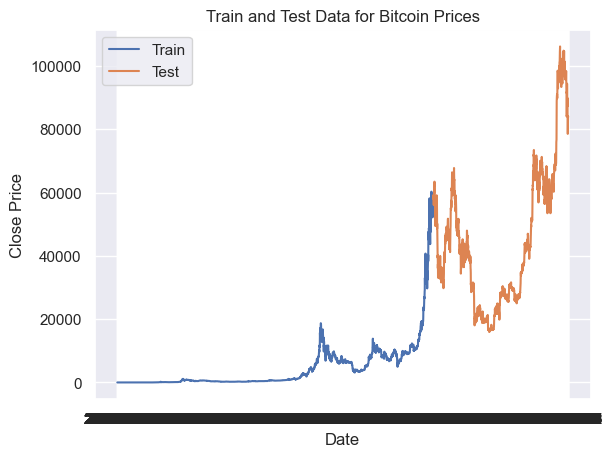

In [99]:
thershold_train=int(len(data)*0.7)
train_data=data[:thershold_train]
test_data=data[thershold_train:]
print(f'the length of train data is = {train_data.shape}')
print(f'the length of test data is = {test_data.shape}')
y_train=train_data['Close'].to_numpy()
y_test=test_data['Close'].to_numpy()

x_train=train_data.index.to_numpy()
x_test=test_data.index.to_numpy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

sns.lineplot(train_data['Close'], label='Train')
sns.lineplot(test_data['Close'], label='Test')
plt.title('Train and Test Data for Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


## Purpose
This code generates a date range for the next 42 days, starting from the last date in the `x_test` array (which contains the test data indices). The `pd.date_range` function creates a list of dates with a daily frequency, and `pd.to_datetime` ensures that the generated dates are in the proper datetime format for further analysis or predictions.


In [21]:
period_date = pd.date_range(start=list(x_test)[-1], periods=42, freq='1d').tolist()
period_date = pd.to_datetime(period_date)

# Naive Forecast Model (Naive Bias)

### Purpose
The `naive_forecast` variable creates a naive forecast for the test data by using the previous day's actual closing price as the forecast for the next day. It does this by removing the last value from `y_test` (actual closing prices) and using the rest of the values as the forecast. This is a simple approach often referred to as the **naive bias**, which assumes that future values will be the same as the most recent observed value.

This method serves as a baseline model to compare the performance of more advanced forecasting models. If a model cannot outperform the naive forecast, it is considered ineffective.

### Example
- If `y_test` is `[100, 105, 110, 120]`, the naive forecast would be `[100, 105, 110]` for the first three days. The last day's value (120) is not included because there's no value to forecast it from in the naive model.


In [22]:
naive_forecast=y_test[:-1]
naive_forecast

array([59118.91, 58582.36, 58899.97, ..., 83620.  , 83677.  , 83975.  ])

In [24]:
naive_results=evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast)
naive_results

{'mae': 926.60516, 'mse': 2241694.8, 'rmse': 1497.229, 'mape': 2.0893135}

# 2. Dense (Fully Connected) Neural Network

This code defines and trains a deep learning model to predict Bitcoin prices based on historical data, using a sequence of previous values (windows) to forecast the next value (horizon). The model architecture is a feedforward neural network (Dense Neural Network) with multiple layers, and it is trained using Mean Absolute Error (MAE) as the loss function.

### Breakdown:
1. **Window and Label Preparation**:
   - The `make_windows` function is used to create input windows (`full_windows`) and corresponding labels (`full_labels`) based on the `WINDOW_SIZE` (5 days) and `HORIZON` (1 day). This means the model will use 5 days of data to predict the next day's closing price.
   
2. **Train-Test Split**:
   - The `make_train_test_splits` function splits the data into training and test sets.

3. **Model Definition**:
   - A Sequential model (`model_1`) is defined with multiple dense layers, using ReLU activation functions for hidden layers and a linear activation function for the output layer to predict a continuous value.
   
4. **Model Compilation**:
   - The model is compiled with the Adam optimizer and MAE loss function, making it suitable for regression tasks like price prediction.

5. **Model Training**:
   - The model is trained using the `fit` method with training data (`train_Window` and `train_label`), evaluated on test data (`test_window` and `test_label`). The training includes a model checkpoint callback to save the best model during training.

### Hyperparameters:
- **HORIZON = 1**: Predict 1 step (1 day) at a time.
- **WINDOW_SIZE = 5**: Use a window of 5 days of historical data to predict the next day's price.

### Example Output:
- After training, the model's performance will be evaluated on the test data, and the best model will be saved for further use.



In [26]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 5 # use a week worth of timesteps to predict the horizon

In [27]:
full_windows, full_labels = make_windows(data['Close'].values, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
train_Window , test_window,train_label,test_label=make_train_test_splits(full_windows,full_labels)
print(f'train_Window:{train_Window.shape},test_window:{test_window.shape},train_label:{train_label.shape},test_label:{test_label.shape}')

train_Window:(3854, 5),test_window:(964, 5),train_label:(3854, 1),test_label:(964, 1)


In [28]:
model_1=tf.keras.Sequential([
    tf.keras.layers.Dense( 256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(HORIZON,activation='linear')
],name='model_1_dense')

model_1.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae']
)

In [29]:
history=model_1.fit(x=train_Window,y=train_label,epochs=100,verbose=1,batch_size=16,validation_data=(test_window, test_label),callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
218/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1558.9329 - mae: 1558.9329
Epoch 1: val_loss improved from inf to 2049.09399, saving model to D:\data science projects\project 2 unfinished\model_1_dense.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1476.1213 - mae: 1476.1213 - val_loss: 2049.0940 - val_mae: 2049.0940
Epoch 2/100
237/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 404.4493 - mae: 404.4493
Epoch 2: val_loss improved from 2049.09399 to 1002.76477, saving model to D:\data science projects\project 2 unfinished\model_1_dense.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 404.2159 - mae: 404.2159 - val_loss: 1002.7648 - val_mae: 1002.7648
Epoch 3/100
231/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 377.3945 - mae: 377.3945
Epoch 3: val_loss did not improve from 1002.76477
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 377.6383 - mae: 377.6383 - val_loss: 1003.5146 - val_mae: 1003.5146
Epoch 4/100
227/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 357

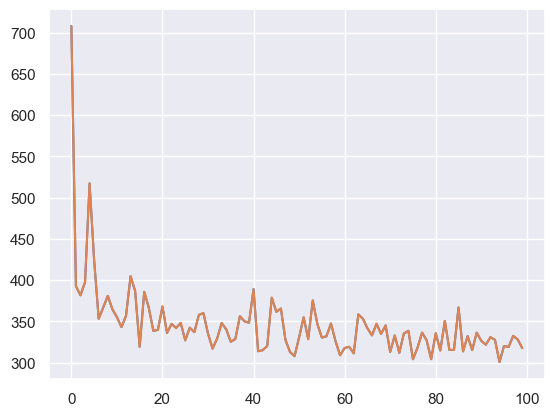

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])

In [31]:
model_1 = tf.keras.models.load_model(r"D:\data science projects\project 2 unfinished\model_1_dense.keras")
dense_forecast=model_1.predict(test_window)
forecast=tf.squeeze(dense_forecast)
model_1_prefor=evaluate_preds(y_true=test_label,y_pred=dense_forecast)
model_1_prefor

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


{'mae': 829.5685, 'mse': 2097441.2, 'rmse': 1448.2545, 'mape': 1.7476029}

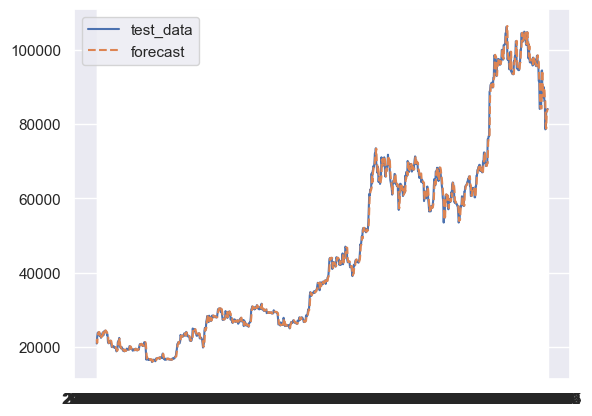

In [32]:
plt.plot(x_test[-len(test_window):],test_label[:,0],label='test_data')
plt.plot(x_test[-len(test_window):],dense_forecast,label='forecast',linestyle="--")
plt.legend()

---
** This code generates a 42-day forecast for Bitcoin prices using the previously trained model, starting from the last known window in the dataset. It then compares the forecasted values with actual Bitcoin prices for the next 30 days.

### Steps:

1. **Starting from the Last Window**:
   - The last window (`last_window`) of data is taken from the `full_windows` array, which contains the most recent historical data. This window will serve as the starting point for the forecast.

2. **Iterative Forecasting**:
   - The model is used to predict the next price in the sequence for 42 days. The forecasted value is appended to the current window, and the window is updated by removing the first value and adding the newly predicted value. This process is repeated for 42 days, generating the forecast.

3. **Storing Forecast**:
   - The forecasted values (`forecast_30`) are stored in a `DataFrame` (`model_1_forecast`), with the corresponding date range (`period_date`) as the index.

4. **Actual Data**:
   - The actual Bitcoin price data for the next 30 days is retrieved using the `actual_30_days` function.

5. **Visualization**:
   - The `plot_actual_forecast` function is used to plot both the forecasted and actual Bitcoin prices, allowing for a comparison between the model's predictions and the real price movements.

### Outcome:
- The model generates a forecast for the next 42 days, and this forecast is visualized alongside actual data, providing insight into how well the model predicts Bitcoin price movements.



In [34]:
# Start with the last window from your original series
last_window = full_windows[-1]  # shape should be (WINDOW_SIZE,)
forecast_30 = []
current_window = last_window

for _ in range(42):
    pred = model_1.predict(current_window[np.newaxis], verbose=0)
    forecast_30.append(pred[0][0])
    current_window = np.append(current_window[1:], pred[0][0])

forecast_30 = np.array(forecast_30)
model_1_forecast=pd.DataFrame(
    {
        'datetime':period_date,
        'forecast':forecast_30
    }
)

model_1_forecast.set_index('datetime', inplace=True)
model_1_forecast.head()



,forecast
datetime,
2025-03-15,84139.054688
2025-03-16,84340.726562
2025-03-17,84413.492188
2025-03-18,84507.031250
2025-03-19,84595.906250


In [35]:
#actual data
actualData=actual_30_days()

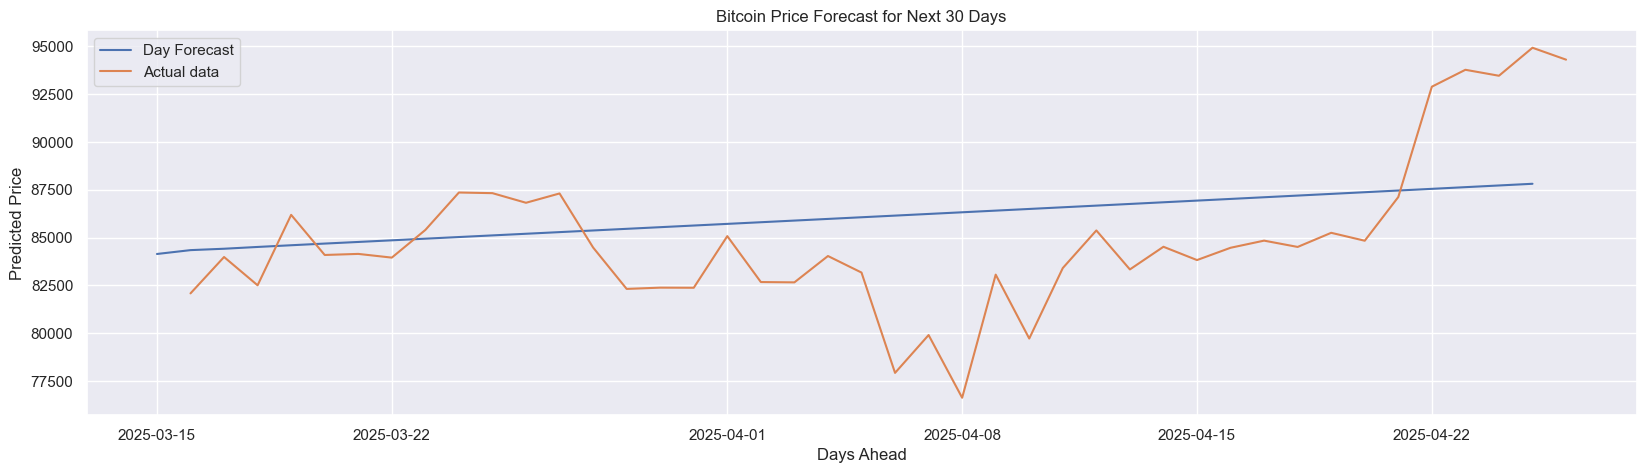

In [36]:
plot_actual_forecast(model_1_forecast,actualData)

In [88]:
model_1_error_forecast=evaluate_preds(y_pred=forecast_30,y_true=actualData.values)
model_1_error_forecast

{'mae': 41663.69, 'mse': 2231003600.0, 'rmse': 47233.5, 'mape': 48.5241}

## 2. LSTM (Long Short-Term Memory) Network

This code defines, trains, and evaluates an LSTM (Long Short-Term Memory) model to predict Bitcoin prices using historical data. The model is built to forecast one step at a time (HORIZON = 1) using a sliding window of 9 previous days of data (WINDOW_SIZE = 9). The training data and test data are split, and the model is trained using the Adam optimizer. The performance is evaluated using Mean Absolute Error (MAE) and Mean Squared Error (MSE).

### Steps:

1. **Window and Label Preparation**:
   - The `make_windows` function is used to create the input windows (`full_windows`) and labels (`full_labels`) based on the `WINDOW_SIZE` (9 days) and `HORIZON` (1 day). This means the model will use the past 9 days to predict the next day's closing price.

2. **Train-Test Split**:
   - The `make_train_test_splits` function splits the data into training and test sets, which are then used for training the model and evaluating its performance.

3. **Model Definition (LSTM)**:
   - An LSTM-based model (`model_2`) is created with multiple layers of LSTM cells, each followed by a ReLU activation function. The LSTM layers are stacked to capture complex sequential patterns, and a dropout layer is added to prevent overfitting.
   - The model is compiled with the Adam optimizer and MAE loss function. It uses a learning rate of 1e-3 for optimization and evaluates using MSE.

4. **Model Training**:
   - The model is trained using the `fit` method with training data (`train_Window` and `train_label`) for 50 epochs. The validation data (`test_window` and `test_label`) is used to monitor the model's performance on unseen data. A model checkpoint callback is used to save the best model during training.

5. **Plotting Results**:
   - After training, the forecasted values (`lstm_forecast`) are plotted against the test data to visualize the model's predictions. The `x_test` and `test_label` are used for plotting the actual and forecasted Bitcoin prices.

6. **Model Evaluation**:
   - The performance of the model is evaluated using the `evaluate_preds` function, which compares the predicted values (`lstm_forecast`) with the actual test labels (`test_label`) to compute the error metrics.

### Hyperparameters:
- **HORIZON = 1**: Predict one step (1 day) at a time.
- **WINDOW_SIZE = 9**: Use the last 9 days of data to predict the next day's closing price.
- **Batch Size = 64**: The model is trained with a batch size of 64.

### Outcome:
- The model is trained, and after training, the forecast is visualized alongside the actual data. The model's error is evaluated using MAE and MSE.


In [40]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 9 # use a week worth of timesteps to predict the horizon

In [41]:
full_windows, full_labels = make_windows(data['Close'].values, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
train_Window , test_window,train_label,test_label=make_train_test_splits(full_windows,full_labels)
print(f'train_Window:{train_Window.shape},test_window:{test_window.shape},train_label:{train_label.shape},test_label:{test_label.shape}')

train_Window:(3851, 9),test_window:(963, 9),train_label:(3851, 1),test_label:(963, 1)


In [42]:
train_Window = train_Window[..., np.newaxis]  # shape becomes (num_samples, 5, 1)
test_window = test_window[..., np.newaxis]

train_Window.shape

(3851, 9, 1)

In [43]:

model_2=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE,HORIZON)),
    LSTM(1024,activation='relu',return_sequences=True),
    LSTM(512,activation='relu',return_sequences=True),
    LSTM(256,activation='relu',return_sequences=True),
   # LSTM(128,activation='relu',return_sequences=True),
    LSTM(64,activation='relu',return_sequences=True),
    LSTM(32,activation='relu',return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    LSTM(64,activation='relu'),
    tf.keras.layers.Dense(HORIZON,activation='linear')
],name='model_2_lstm')
model_2.compile(loss='mae',optimizer=tf.keras.optimizers.Adam( learning_rate=1e-3),metrics=['mse'])



In [ ]:
model_2.summary()

In [ ]:
#best batch_size=64
model_2.fit(train_Window,train_label,verbose=1,epochs=50,batch_size=64,validation_data=(test_window, test_label),callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 8765.8164 - mse: 294849344.0000
Epoch 1: val_loss improved from inf to 10453.28516, saving model to D:\data science projects\project 2 unfinished\model_2_lstm.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 357ms/step - loss: 8727.9746 - mse: 293042432.0000 - val_loss: 10453.2852 - val_mse: 162926080.0000
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 2257.4724 - mse: 30970080.0000
Epoch 2: val_loss did not improve from 10453.28516
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - loss: 2249.4587 - mse: 30784756.0000 - val_loss: 10776.1943 - val_mse: 163135600.0000
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 2268.9502 - mse: 26148516.0000
Epoch 3: val_loss improved from 10453.28516 to 5313.28320, saving model to D:\data science projects\project 2 unfinished\model_2_lstm.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - loss: 2259.9377 - mse: 25987746.0000 - val_loss: 5313.2832 - val_mse: 46124344.0000
Epoch 4/50
31

In [46]:
model_2 = tf.keras.models.load_model(r"D:\data science projects\project 2 unfinished\model_2_lstm.keras")
lstm_forecast=model_2.predict(test_window)

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step


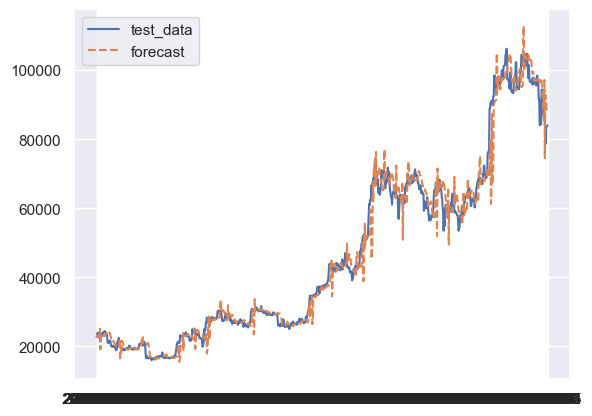

In [47]:
plt.plot(x_test[-len(test_window):],test_label[:,0],label='test_data')
plt.plot(x_test[-len(test_window):],lstm_forecast,label='forecast',linestyle="--")
plt.legend()

In [48]:
model_2_error=evaluate_preds(test_label,lstm_forecast)
model_2_error

{'mae': 2490.037, 'mse': 16169772.0, 'rmse': 4021.1655, 'mape': 5.2846274}

In [49]:
forecast_30 = []
last_window = full_windows[-1] 
current_window = last_window
for _ in range(42):
    pred = model_2.predict(current_window.reshape(1, WINDOW_SIZE, 1), verbose=0)
    forecast_30.append(pred[0][0])  # assuming output shape is (1, 1)
    # Shift window and append new prediction
    current_window = np.append(current_window[1:], pred[0][0])
forecast_30 = np.array(forecast_30)


model_2_forecast=pd.DataFrame(
    {
        'datetime':period_date,
        'forecast':forecast_30
    }
)

model_2_forecast.set_index('datetime',inplace=True)


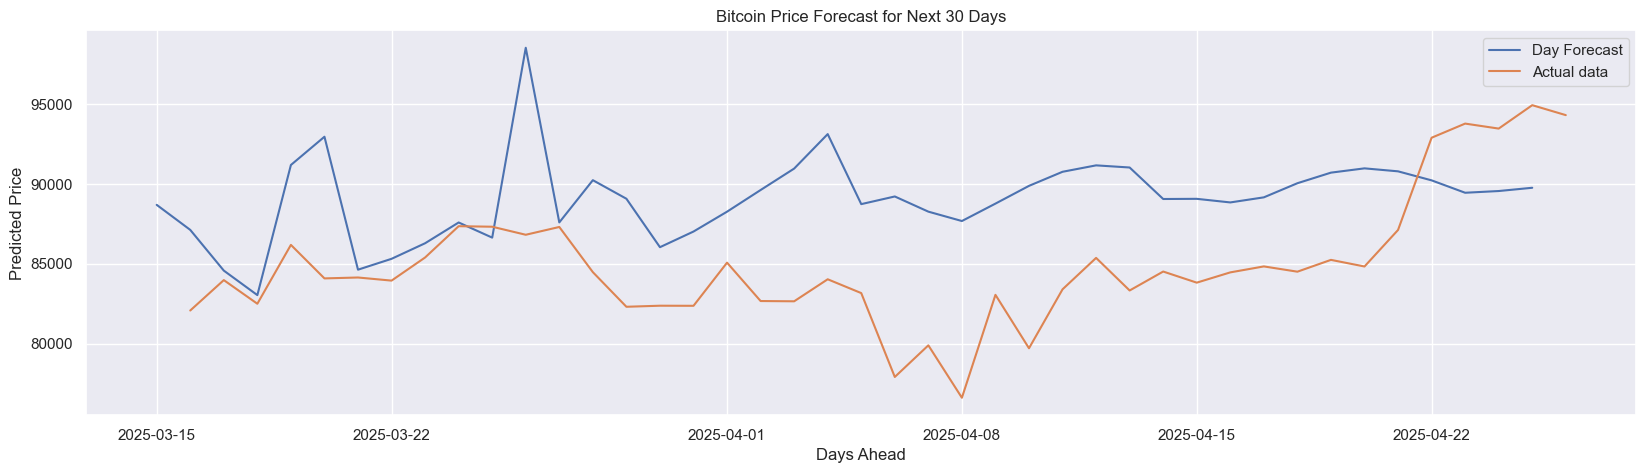

{'mae': 5272.124, 'mse': 36748268.0, 'rmse': 6062.035, 'mape': 6.2978506}

In [50]:
plot_actual_forecast(forecast=model_2_forecast,actualData=actualData)
model_2_forecast_error=evaluate_preds(y_pred=model_2_forecast.values,y_true=actualData.values)
model_2_forecast_error


## 3. Bi-LSTM (Bidirectional LSTM) Network

In this section, we define and train a **Bidirectional LSTM (Bi-LSTM)** model to predict Bitcoin prices using historical data. The model utilizes past closing prices for multiple time steps to predict future price movements. The **Bidirectional LSTM** helps the model capture sequential patterns both from the past and the future, which is particularly useful for time series forecasting.

### Steps:

1. **Model Definition (Bidirectional LSTM)**:
   - A **Bidirectional LSTM** is used for each LSTM layer, meaning the model processes the data in both forward and backward directions. This allows the model to capture more complex patterns in the data.
   - The model architecture includes multiple LSTM layers with decreasing sizes (256, 128, 128, 64, 32 units), each followed by a ReLU activation function. The final layer outputs the predicted value for the next time step.
   - The **Adam optimizer** is used with a learning rate of `1e-4`, and the model is trained with the **Mean Absolute Error (MAE)** loss function.

2. **Training the Model**:
   - The model is trained using the training data (`train_Window`, `train_label`) for 100 epochs with a batch size of 64. The validation data (`test_window`, `test_label`) is used to monitor performance during training. A **ModelCheckpoint callback** is used to save the best model during training.

3. **Loading the Best Model**:
   - After training, the best model is loaded from the saved checkpoint file (`model_3_bilstm.keras`).

4. **Making Forecasts**:
   - The model is used to generate predictions for the test set (`test_window`). The predictions are then plotted against the actual test data to visualize the model's performance.

5. **Forecasting for the Next 42 Days**:
   - The last window of the training data is used to generate forecasts for the next 42 days. The predictions are appended iteratively, updating the window with each new forecast.

6. **Plotting the Forecast**:
   - The forecast for the next 42 days is plotted alongside the actual data. The actual data is retrieved using the `actual_30_days()` function and is visualized to compare how well the model's predictions align with the real Bitcoin price movements.

7. **Model Evaluation**:
   - The model's performance is evaluated using **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**. The errors are computed for both the test data and the 42-day forecast.

### Hyperparameters:
- **HORIZON = 1**: Predict one step (1 day) at a time.
- **WINDOW_SIZE = 9**: Use the last 9 days of data to predict the next day's closing price.
- **Batch Size = 64**: The model is trained with a batch size of 64.
- **Learning Rate = 1e-4**: The learning rate for the Adam optimizer.

### Outcome:
- The model's forecast for the next 42 days is compared with the actual data, and the error metrics are computed for both the test data and the 42-day forecast.


In [52]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE,HORIZON)),
    Bidirectional(LSTM(256,return_sequences=True,activation='relu')),
    Bidirectional(LSTM(128,return_sequences=True,activation='relu')),
    Bidirectional(LSTM(128,return_sequences=True,activation='relu')),      
    Bidirectional(LSTM(64,return_sequences=True,activation='relu')),
    Bidirectional(LSTM(32,return_sequences=False,activation='relu')),
    Dense(HORIZON,activation='linear')
],name='model_3_bilstm')


model_3.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['mse'])

In [53]:
model_3.summary()

Model: "model_3_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 9, 512)         │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 9, 256)         │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 9, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 9, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,784,641 (6.81 MB)

 Trainable params: 1,784,641 (6.81 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model_3.fit(train_Window,train_label,verbose=1,epochs=100,batch_size=64,validation_data=(test_window,test_label),callbacks=(create_model_checkpoint(model_name=model_3.name)))

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 8977.0381 - mse: 300272576.0000
Epoch 1: val_loss improved from inf to 45880.04688, saving model to D:\data science projects\project 2 unfinished\model_3_bilstm.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 46s 216ms/step - loss: 8982.7402 - mse: 300580192.0000 - val_loss: 45880.0469 - val_mse: 2760208640.0000
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 9205.3701 - mse: 305249568.0000
Epoch 2: val_loss improved from 45880.04688 to 43729.62500, saving model to D:\data science projects\project 2 unfinished\model_3_bilstm.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 9200.7051 - mse: 305029472.0000 - val_loss: 43729.6250 - val_mse: 2509583616.0000
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 8724.7910 - mse: 280057312.0000
Epoch 3: val_loss did not improve from 43729.62500
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 8726.9873 - mse: 280186592.0000 - val_loss: 43974.8164 - val_mse: 2537646848.0

In [55]:
model_3 = tf.keras.models.load_model(r"D:\data science projects\project 2 unfinished\model_3_bilstm.keras")
bilstm_forecast=model_3.predict(test_window)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


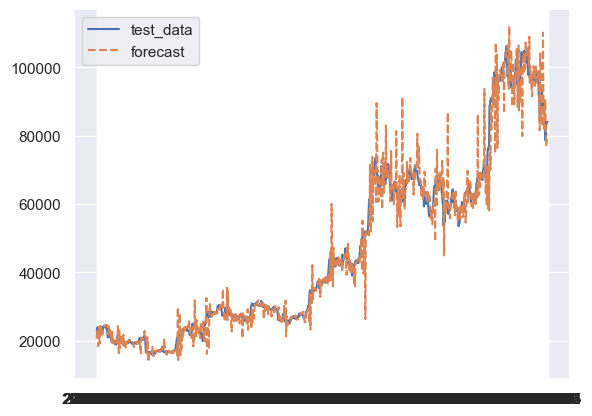

In [56]:
plt.plot(x_test[-len(test_window):],test_label[:,0],label='test_data')
plt.plot(x_test[-len(test_window):],bilstm_forecast,label='forecast',linestyle="--")
plt.legend()
plt.show()

In [57]:
model_3_error=evaluate_preds(test_label,bilstm_forecast)
model_3_error

{'mae': 2664.316, 'mse': 20954882.0, 'rmse': 4577.6504, 'mape': 5.6432996}

In [58]:
forecast_30 = []
last_window = full_windows[-1] 
current_window = last_window
for _ in range(42):
    pred = model_3.predict(current_window.reshape(1, WINDOW_SIZE, 1), verbose=0)
    forecast_30.append(pred[0][0])
    current_window = np.append(current_window[1:], pred[0][0])
forecast_30 = np.array(forecast_30)


model_3_forecast=pd.DataFrame(
    {
        'datetime':period_date,
        'forecast':forecast_30
    }
)

model_3_forecast.set_index('datetime',inplace=True)


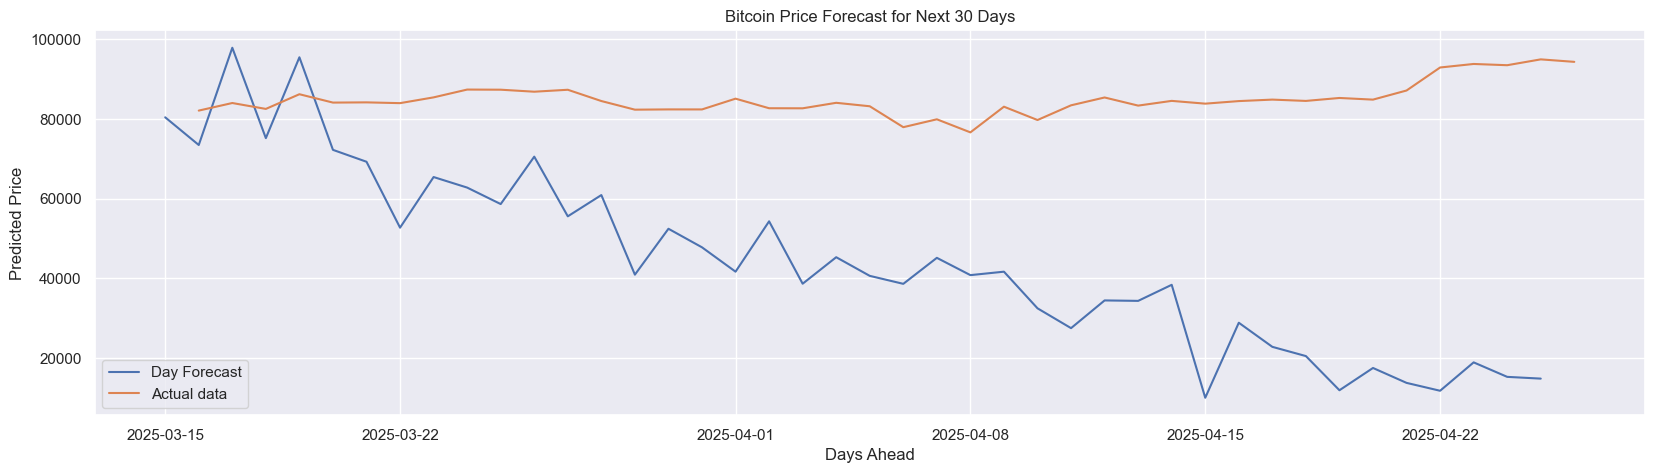

{'mae': 41663.69, 'mse': 2231003600.0, 'rmse': 47233.5, 'mape': 48.524097}

In [59]:
plot_actual_forecast(forecast=model_3_forecast,actualData=actualData)
model_3_forecast_error=evaluate_preds(y_pred=model_3_forecast.values,y_true=actualData.values)
model_3_forecast_error


## 4. ARIMA (AutoRegressive Integrated Moving Average) Model

In this section, we use the **AutoRegressive Integrated Moving Average (ARIMA)** model to forecast Bitcoin prices based on the historical data. ARIMA models are popular for time series forecasting, particularly when the data is stationary or can be made stationary through differencing.

### Steps:

1. **Stationarity Check**:
   - The **Augmented Dickey-Fuller (ADF) Test** is used to check if the Bitcoin price data is stationary. If the p-value is greater than 0.05, the data is considered non-stationary.
   - Differencing is applied to the data (`diff_df`) to make it stationary. The ADF test is then performed on the differenced data.

2. **Autocorrelation and Partial Autocorrelation**:
   - The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots are generated to understand the correlation structure in the data. These plots help in determining the order of the ARIMA model.
   - ACF is used to identify the lag for the moving average (MA) component, while PACF helps to identify the lag for the autoregressive (AR) component.

3. **ARIMA Model Fitting**:
   - The **ARIMA** model is fit to the differenced data. The appropriate order of the ARIMA model (p, d, q) is chosen based on the ACF and PACF plots.
   - The model is trained and fitted, and then used to generate forecasts for the next 42 days.

4. **Making Forecasts**:
   - After fitting the ARIMA model, a 42-day forecast is generated.
   - The forecast is plotted alongside the actual data to compare the model's predictions with the observed Bitcoin price movements.

5. **Model Evaluation**:
   - The model's performance is evaluated using **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** by comparing the forecasted values with the actual values.

### Outcome:
- The ARIMA model generates a forecast for the next 42 days, and the forecast is visualized against the actual Bitcoin prices.
- Evaluation metrics are computed to measure the model's prediction accuracy.


In [61]:
adf_test(data['Close'])


ADF Statistic: -0.40226673522269596
p-value: 0.9097196252592958
The series is NOT stationary.


In [62]:
diff_df = data.diff().dropna()


In [63]:
adf_test(diff_df['Close'])

ADF Statistic: -9.602150554420273
p-value: 1.9079159596224348e-16
The series is stationary.


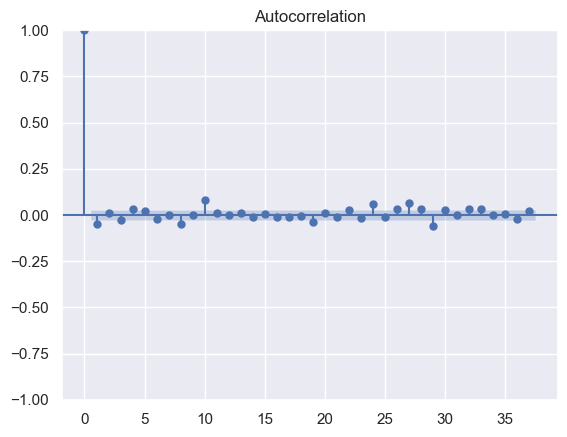

In [ ]:
plot_acf(diff_df['Close'])
plt.show()

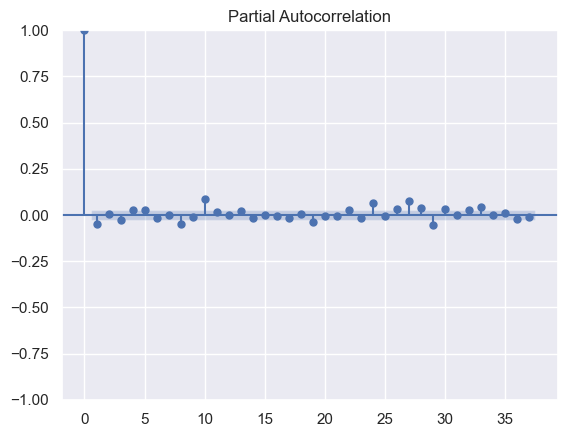

In [65]:
plot_pacf(diff_df['Close'],use_vlines=True)
plt.show()

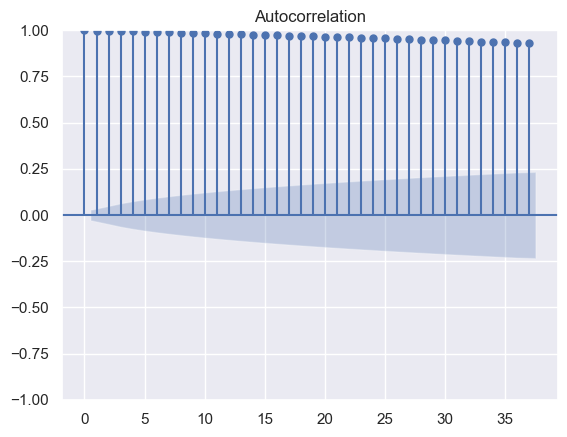

In [66]:
acf=plot_acf(data)

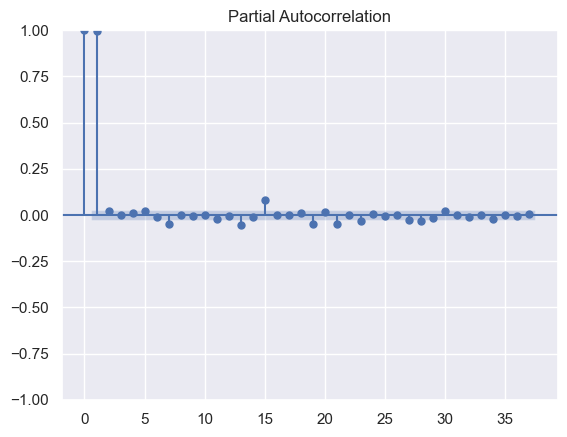

In [67]:
pacf=plot_pacf(data)

In [68]:
actualData=actual_30_days()

In [69]:
model_4 = ARIMA(data, order=(29,1,30))
model_fit=model_4.fit()


c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

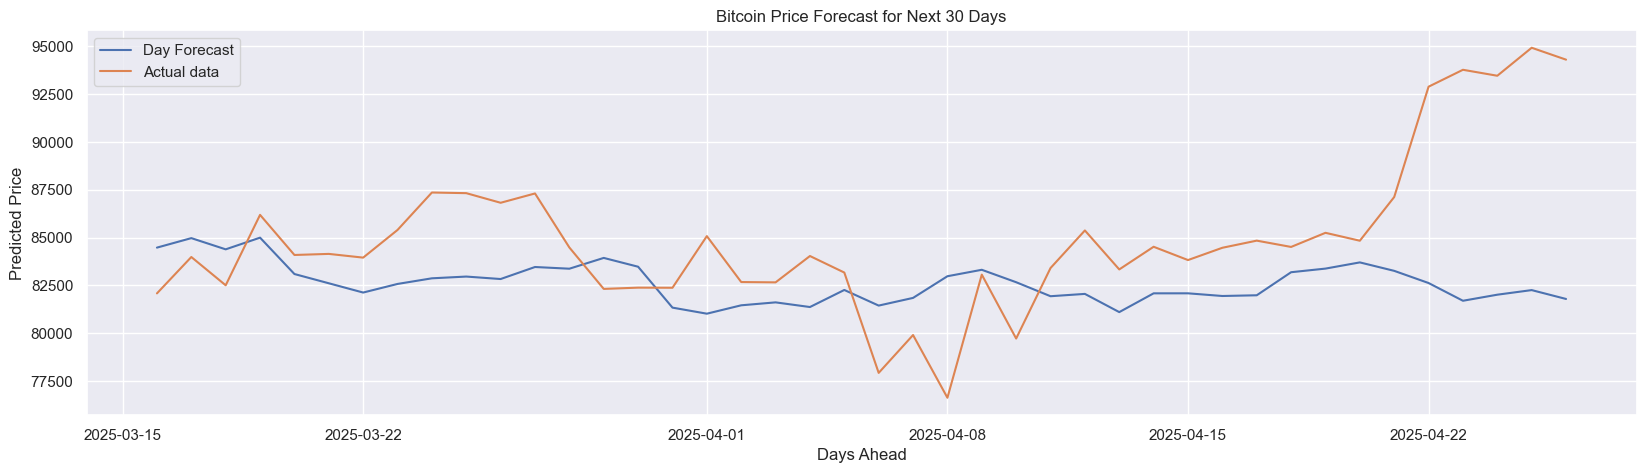

In [70]:
model_4_forecast=model_fit.forecast(steps=42)
plot_actual_forecast(model_4_forecast,actualData)

In [71]:
model_4_error_forecast=evaluate_preds(y_pred=model_4_forecast.values,y_true=actualData.values)
model_4_error_forecast

{'mae': 3426.1514, 'mse': 22810816.0, 'rmse': 4776.067, 'mape': 3.9119642}

## 5. ARIMA Model with Custom Configuration for Bitcoin Price Prediction

In this section, we fit an **ARIMA model** with a custom configuration (order = (15, 1, 15)) and forecast Bitcoin prices for the next 42 days. Additionally, we calculate a prediction for the current date based on the model.

### Steps:

1. **Model Fit (ARIMA)**:
   - An **ARIMA model** with the configuration `(15, 1, 15)` is used, where:
     - **15** is the number of lag observations in the autoregressive part (AR).
     - **1** is the differencing order to make the series stationary.
     - **15** is the number of lag observations in the moving average part (MA).
   - The model is then fitted on the historical data to capture the underlying patterns.

2. **Forecasting for the Next 42 Days**:
   - After fitting the ARIMA model, a forecast is made for the next 42 days using the `forecast()` method.
   - The forecasted values are plotted against the actual data for comparison.

3. **Error Evaluation**:
   - The forecast error is computed using **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** by comparing the predicted values with the actual Bitcoin prices.

4. **Real-Time Forecast for Bitcoin Price**:
   - The current Bitcoin price forecast is generated for the current date. This is achieved by calculating the number of days between a specified start date (e.g., March 15, 2025) and the current date.
   - The model is used to forecast the Bitcoin price for each day until the current date, and the forecasted price for today is extracted.

### Outcome:
- The model provides a 42-day forecast for Bitcoin prices.
- The forecasted values are compared to the actual data to evaluate model performance.
- The predicted Bitcoin price for the current date is outputted.


In [72]:
model_4_2= ARIMA(data, order=(15,1,15))
model_fit_2=model_4_2.fit()

c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


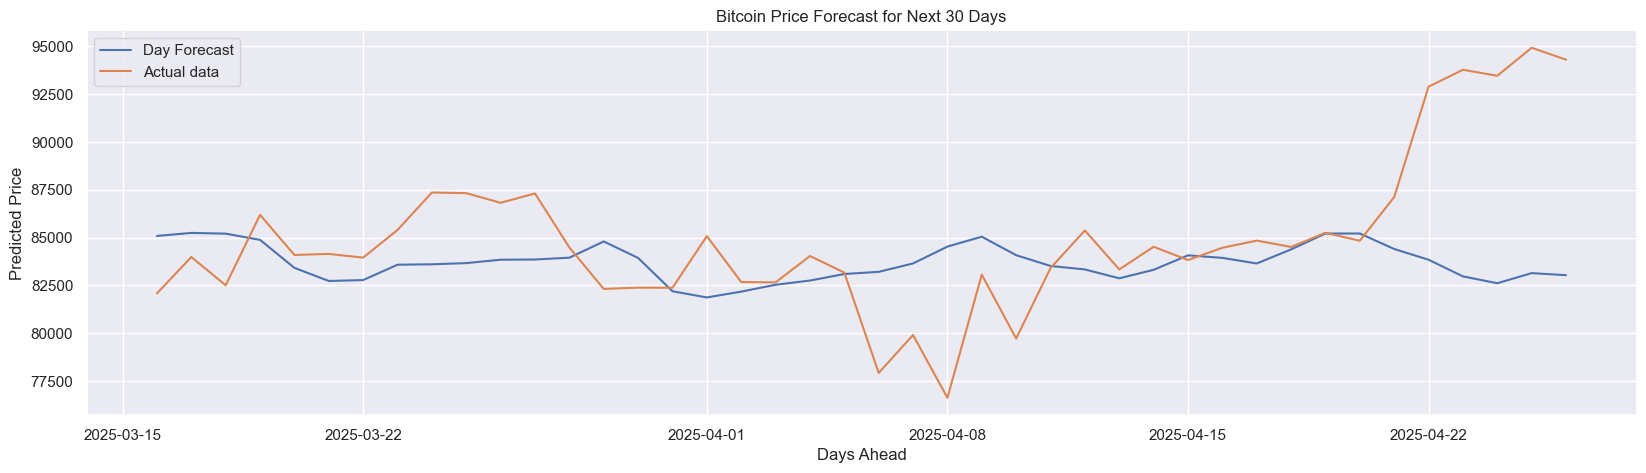

In [73]:
model_4_2_forecast=model_fit_2.forecast(steps=42)
plot_actual_forecast(model_4_2_forecast,actualData)

In [74]:
model_4_2_error_forecast=evaluate_preds(y_pred=model_4_2_forecast.values,y_true=actualData.values)
model_4_2_error_forecast


{'mae': 2935.0715, 'mse': 19560936.0, 'rmse': 4422.775, 'mape': 3.3633285}

In [75]:
from datetime import datetime

# Start and current date
start_date = datetime(2025, 3, 15)
current_date = datetime.today()

# Calculate the number of days
days_difference = (current_date - start_date).days
days_difference


44

In [76]:
bitcoin_price_today_forecast=model_fit.forecast(steps=days_difference);
print(f'the predicted price of the BTC today {current_date} is = {bitcoin_price_today_forecast[-1]}')

the predicted price of the BTC today 2025-04-28 21:49:57.030717 is = 81647.07915298305


## 6. Prophet Model

In this section, we use the **Prophet** model from Facebook to forecast Bitcoin prices for the next 42 days. Prophet is a time series forecasting tool designed to handle daily or seasonal patterns and is especially good with data that has strong seasonal effects and missing data.

### Steps:

1. **Data Preparation**:
   - We use the `wrangle()` function to load and preprocess the Bitcoin data (`btcusd_1-min_data.csv`).
   - We rename the columns to fit Prophet's expected format:
     - `datetime` to `ds` (date stamp).
     - `Close` to `y` (value to be predicted).
   - We drop unnecessary columns such as `Open`, `High`, `Low`, and `Volume`.

2. **Model Creation and Training**:
   - We create a **Prophet model** with the `changepoint_prior_scale` set to 0.7 (default is 0.05). This parameter controls the flexibility of the model in adapting to sudden changes in the data.
   - We fit the model on the preprocessed data (`ds` and `y`).

3. **Forecasting**:
   - The model generates a **future dataframe** with the next 42 days.
   - The forecast is made using the `predict()` method, which includes predicted values (`yhat`) for the forecasted period.

4. **Plotting**:
   - We visualize the forecast alongside the actual data using the `plot_actual_forecast()` function.
   - Additionally, we plot Prophet’s forecasted components (trend, seasonal components) to understand how the model is capturing the data’s behavior.

5. **Error Evaluation**:
   - We calculate the error of the forecast using metrics such as **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** by comparing the predicted values (`forecast`) with the actual data (`actualData`).

### Outcome:
- The model generates a 42-day forecast for Bitcoin prices.
- The forecast is compared against the actual Bitcoin prices to evaluate its performance.
- The components (trend, seasonality) of the forecast are visualized to understand the model's behavior.


In [78]:
data_prophet=wrangle("D:\\data science projects\\project 2 unfinished\\btcusd_1-min_data.csv")
data_prophet=data_prophet.reset_index()
data_prophet = data_prophet.rename(columns={"datetime": "ds", "Close": "y"})
data_prophet=data_prophet.drop(columns=['Open','High','Low','Volume'])

In [81]:
# Create and train the model
model_5= Prophet(changepoint_prior_scale=0.7)  # Default is 0.05
model_5.fit(data_prophet)

21:50:28 - cmdstanpy - INFO - Chain [1] start processing
21:50:33 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
future = model_5.make_future_dataframe(periods=42)
forecast = model_5.predict(future)
model_5_forecast=pd.DataFrame(
    {
        'datetime':future[-42:]['ds'],
        'forecast':forecast[-42:]['yhat']
    }
)

model_5_forecast.set_index('datetime',inplace=True)

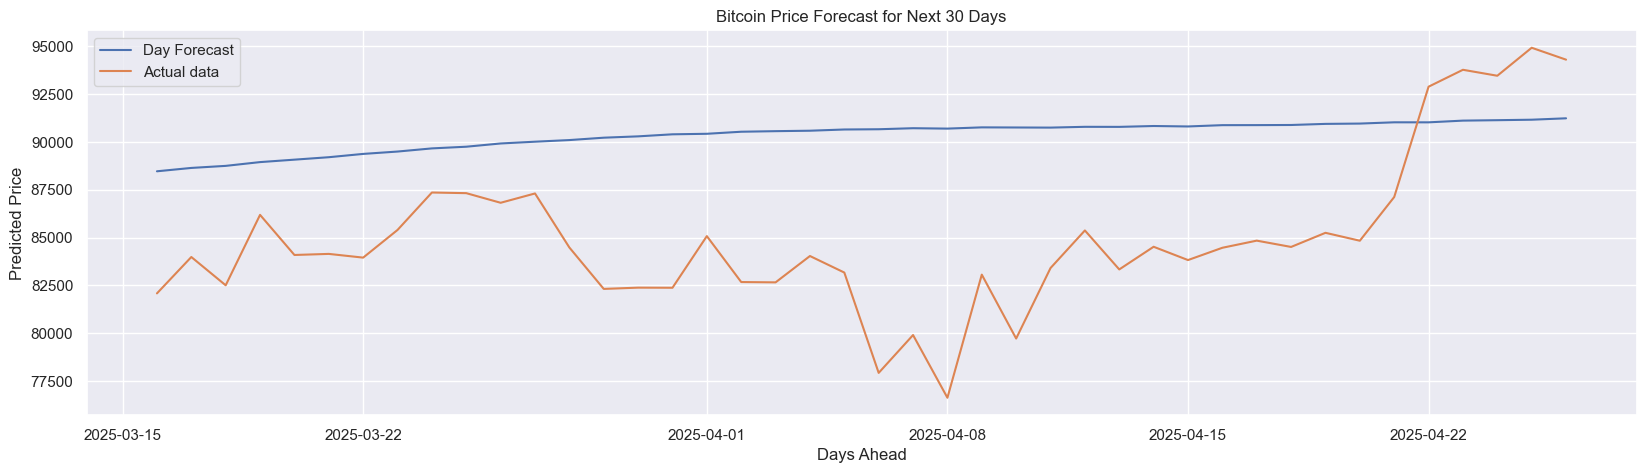

In [83]:
plot_actual_forecast(forecast=model_5_forecast,actualData=actualData)

In [84]:
model_5_error_forecast=evaluate_preds(y_pred=model_5_forecast['forecast'],y_true=actualData.values)
model_5_error_forecast

{'mae': 6023.9097, 'mse': 43750204.0, 'rmse': 6614.3936, 'mape': 7.2322707}

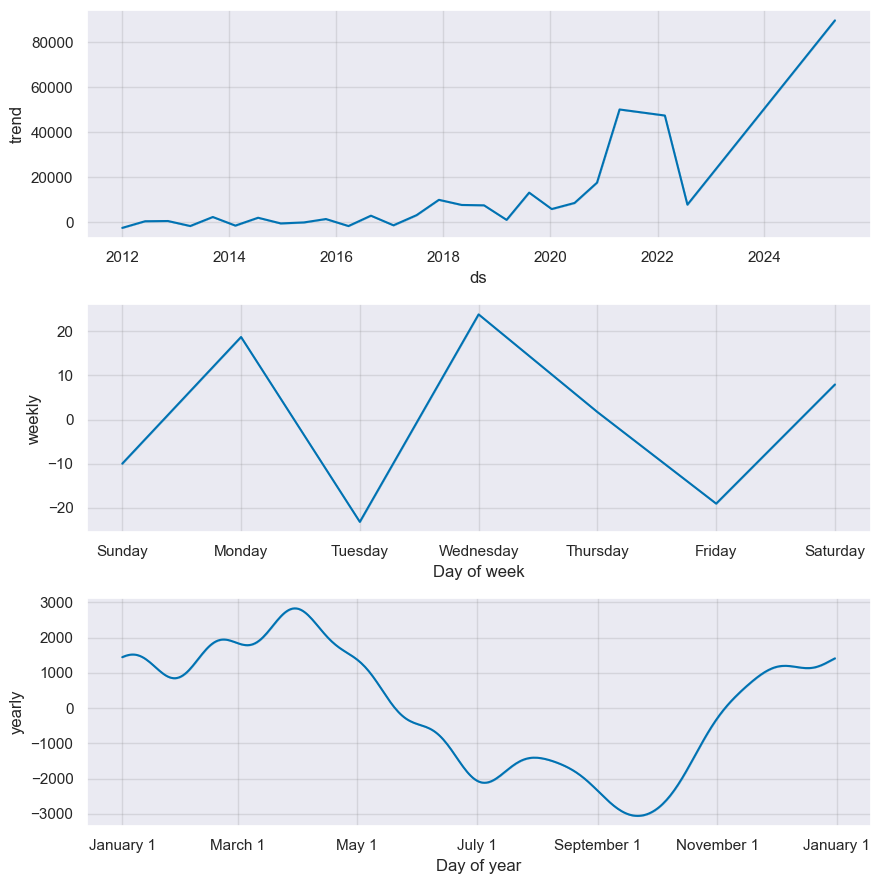

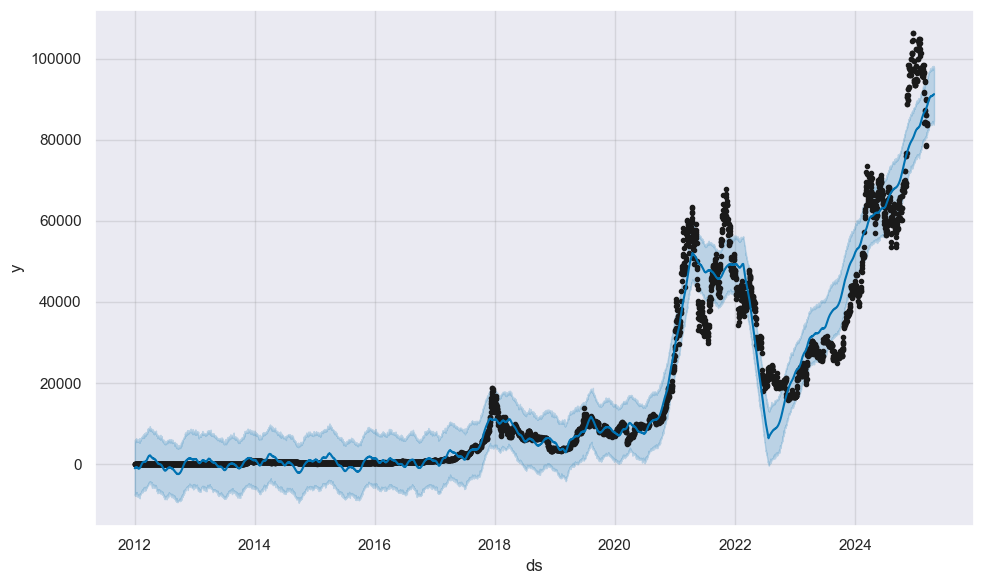

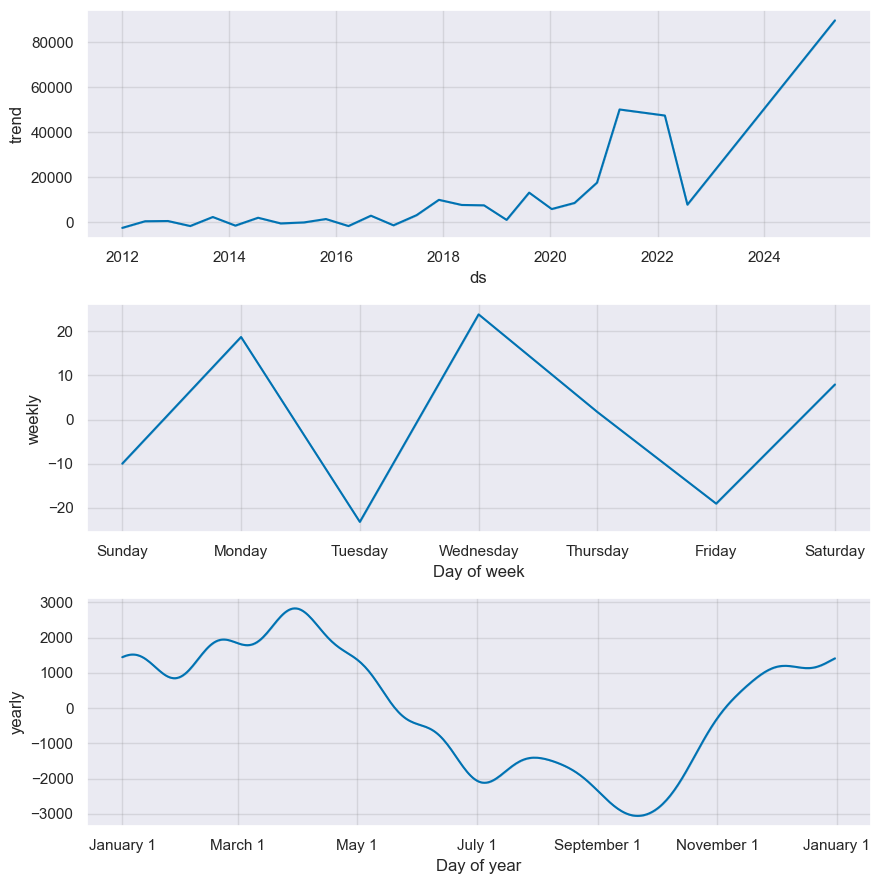

In [85]:
model_5.plot(forecast)
model_5.plot_components(forecast)

## 7. Model Comparison and Visualization

In this section, we compare the performance of various models by plotting their predictions and evaluating their error metrics.

### Models Compared:
1. **Naive Model**: A basic forecast using the last observed value as the prediction.
2. **Model 1 - Dense Neural Network**: A fully connected neural network for regression.
3. **Model 2 - LSTM**: A Long Short-Term Memory (LSTM) network designed to capture time-dependent patterns.
4. **Model 3 - Bidirectional LSTM**: A Bi-LSTM model that captures information from both past and future time steps.
5. **Model 4 - ARIMA (29,1,30)**: A statistical model using differencing and autoregressive terms.
6. **Model 5 - ARIMA (15,1,15)**: Another ARIMA model with different parameters for comparison.
7. **Model 6 - Prophet**: A time series forecasting model designed for handling strong seasonal patterns.

### Steps:
1. **Model Results**:
   - We create a DataFrame (`model_results`) containing the forecast errors (e.g., MAE, MSE) for each model.
   - This allows us to evaluate which model performed best in terms of error metrics.

2. **Plotting the Forecasts**:
   - We plot the predicted Bitcoin prices for each model against the actual data for the next 42 days.
   - The plot includes predictions from:
     - **Model 1 (Dense)**, **Model 2 (LSTM)**, **Model 4 (ARIMA)**, **Model 4_2 (ARIMA_15)**, and **Model 5 (Prophet)**.
     - **Actual data** is also included for comparison.

### Visualization:
The plot provides a clear comparison of how each model predicts Bitcoin prices over the forecast horizon. The models' predictions are plotted with different labels, making it easy to compare their trends.

The legend helps identify each model, and the grid makes it easier to visualize the changes in predicted Bitcoin prices over time.

### Outcome:
- **Error Metrics**: We can refer to the `model_results` DataFrame to determine which model performs the best.
- **Plot**: The line plot shows the forecasted Bitcoin prices from multiple models, allowing visual comparison with actual data.


In [89]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_Dense": model_1_error_forecast,
                              "model_2_lstm": model_2_forecast_error,
                              "model_3_bilstm": model_3_forecast_error,
                              "model_4_arima(29,1,30)": model_4_error_forecast,
                              "model_5_arima(15,1,15)": model_4_2_error_forecast,
                              "model_6_prophet": model_5_error_forecast,}).T
model_results.head(10)

,mae,mse,rmse,mape
naive_model,926.605164,2.241695e+06,1497.229004,2.089314
model_1_Dense,41663.691406,2.231004e+09,47233.500000,48.524101
model_2_lstm,5272.124023,3.674827e+07,6062.035156,6.297851
model_3_bilstm,41663.691406,2.231004e+09,47233.500000,48.524097
"model_4_arima(29,1,30)",3426.151367,2.281082e+07,4776.066895,3.911964
"model_5_arima(15,1,15)",2935.071533,1.956094e+07,4422.774902,3.363328
model_6_prophet,6023.909668,4.375020e+07,6614.393555,7.232271


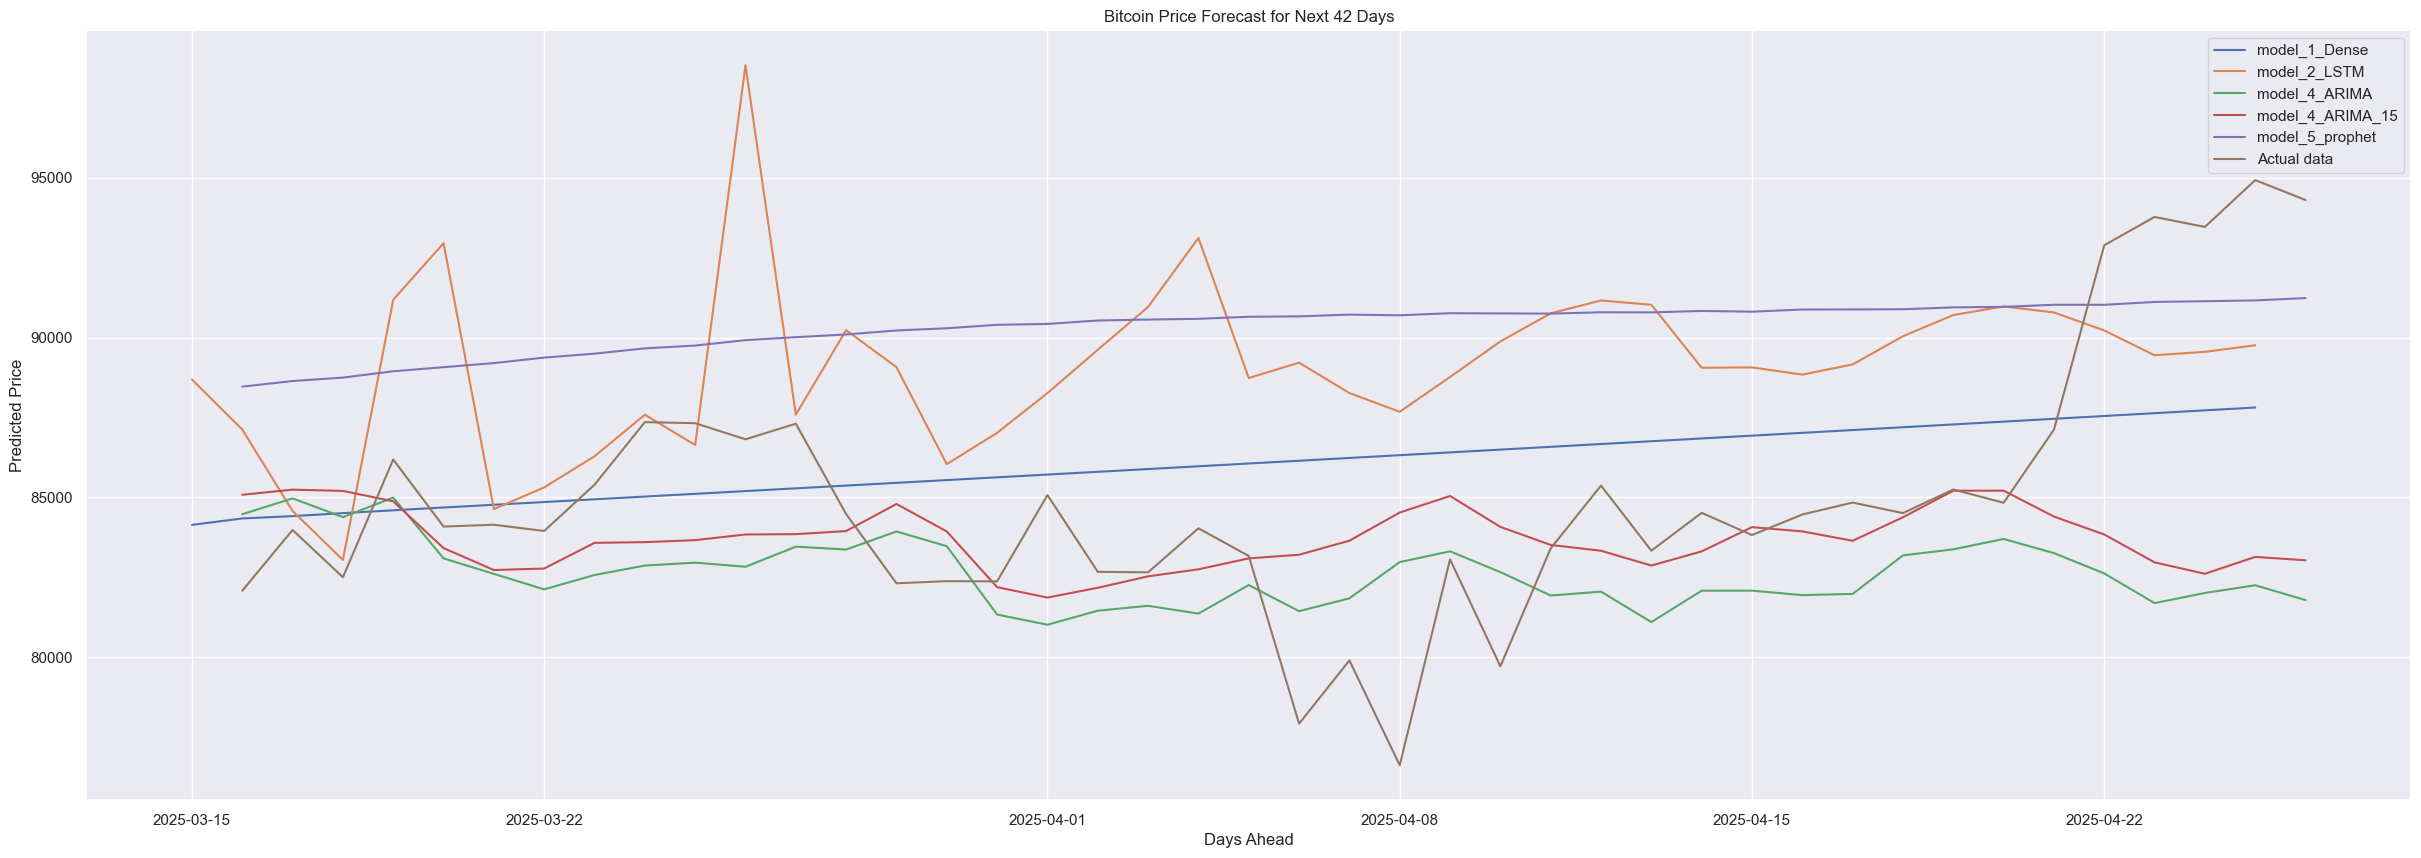

In [98]:
plt.figure(figsize=(30, 10))
plt.plot(model_1_forecast.index, model_1_forecast.values, label='model_1_Dense')
plt.plot(model_2_forecast.index, model_2_forecast.values, label='model_2_LSTM')
#plt.plot(model_3_forecast.index, model_3_forecast.values, label='model_3_BILSTM')
plt.plot(model_4_forecast.index, model_4_forecast.values, label='model_4_ARIMA')
plt.plot(model_4_2_forecast.index, model_4_2_forecast.values, label='model_4_ARIMA_15')
plt.plot(model_5_forecast.index, model_5_forecast.values, label='model_5_prophet')
plt.plot(actualData.index,actualData.values,label='Actual data')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted Price')
plt.title('Bitcoin Price Forecast for Next 42 Days')
plt.legend()
plt.grid(True)
plt.show()

# 📋 Conclusion

## Project Overview

In this project, we aimed to forecast Bitcoin prices using a variety of modeling techniques including deep learning (Dense Neural Network, LSTM, Bi-LSTM), traditional statistical models (ARIMA), and hybrid models (Prophet).  
We evaluated the models based on key metrics: **MAE**, **MSE**, **RMSE**, and **MAPE**, and visualized the forecasts over a 42-day horizon.

---

## Model Performance Summary

| Model                  | MAE        | MSE         | RMSE       | MAPE    |
|-------------------------|------------|-------------|------------|---------|
| Naive Model             | 926.61     | 2.24e+06    | 1497.23    | 2.08    |
| Dense Neural Network    | 41663.69   | 2.23e+09    | 47233.50   | 48.52   |
| LSTM                    | 5272.12    | 3.67e+07    | 6062.04    | 6.30    |
| Bi-LSTM                 | 41663.69   | 2.23e+09    | 47233.50   | 48.52   |
| ARIMA (29,1,30)         | 3426.15    | 2.18e+07    | 4776.07    | 3.91    |
| ARIMA (15,1,15)         | **2935.08**| **1.96e+07**| **4422.77**| **3.36**|
| Prophet                 | 6023.91    | 4.37e+07    | 6614.39    | 7.23    |

---

## Key Observations

- 🔹 **ARIMA (15,1,15)** achieved the **best overall performance** across all metrics (lowest MAE, MSE, RMSE, and MAPE).
- 🔹 **ARIMA (29,1,30)** also performed well, slightly worse than the tuned ARIMA (15,1,15).
- 🔹 **LSTM** outperformed both Dense and Bi-LSTM models significantly, showing that sequential models can better capture temporal dependencies.
- 🔹 **Dense Neural Network** and **Bi-LSTM** models had very high errors, suggesting that either:
  - They were **underfitting** or **overfitting**.
  - Or they **require better feature engineering or hyperparameter tuning**.
- 🔹 **Prophet** model performed moderately well but was slightly less accurate compared to ARIMA and LSTM.
- 🔹 Surprisingly, the **naive forecast** performed better than Dense and Bi-LSTM networks, highlighting how crucial it is to always have a baseline model.

---

## Forecast Visualization Insights

- The **ARIMA models** closely followed the **actual Bitcoin price trends** with much smaller deviations.
- The **LSTM predictions** captured some volatility but showed instability in long-term forecasts.
- The **Dense** and **Bi-LSTM models** mostly predicted smoothed upward trends and missed the fluctuations of Bitcoin prices.
- The **Prophet model** captured the general trend but failed to capture abrupt movements and volatility accurately.

---

## Final Takeaways

- **Traditional statistical models (ARIMA)** can still **outperform deep learning models** in financial time series forecasting, especially with limited and noisy data.
- **Deep learning models (LSTM)** show promise but require **careful tuning, more data, and additional features** (e.g., technical indicators, external factors).
- **Baseline models (like Naive Forecast)** are essential for meaningful model comparisons.
- **Prophet** is a good starting point for practitioners needing quick forecasts but may not match fine-tuned models for accuracy in high-volatility assets like Bitcoin.

---

# 🎯 Future Work Suggestions

- Fine-tune the LSTM and Bi-LSTM models with **more layers, neurons, and dropout**.
- Engineer additional features like **moving averages, RSI, MACD**, and **trading volume**.
- Explore **attention mechanisms** or **Transformer-based architectures** for better long-term dependencies.
- Test **ensemble approaches** (combining ARIMA, LSTM, Prophet) for more robust forecasts.
- Incorporate **external variables** (news sentiment, stock indices) to improve model performance.

---

# 🚀 Final Words

BitPredict provided a valuable exploration of different forecasting techniques on Bitcoin price data.  
Through this project, we gained insights into model strengths, weaknesses, and practical challenges when working with volatile financial time series data.
